# Diffusion Training and Experimentation

This notebook demonstrates training Diffusion model on the MNIST dataset using a modular training pipeline implemented in PyTorch Lightning.


In [1]:
!git clone https://github.com/Reennon/gen-ai-cv-2-3.git
%cd gen-ai-cv-2-3

Cloning into 'gen-ai-cv-2-3'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 406 (delta 32), reused 56 (delta 20), pack-reused 335 (from 1)
Receiving objects: 100% (406/406), 3.94 MiB | 19.30 MiB/s, done.
Resolving deltas: 100% (195/195), done.
/content/gen-ai-cv-2-3


In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   

In [3]:
!git pull

Already up to date.


In [4]:
import os
import dotenv
import wandb
import torch

from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from src.training.latent_diffusion_module import LatentDiffusionModel
from src.training.trainer import train_model

from google.colab import userdata

In [5]:
os.environ["WANDB_KEY"] = userdata.get("wandb_key")
!echo $WANDB_KEY >> .env

In [6]:
dotenv.load_dotenv()

True

In [7]:
parameters = OmegaConf.load("./params/latent_diffusion.yml")
wandb.login(key=os.environ["WANDB_KEY"])

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
wandb_project_name = "latent-diffusion-mnist"
device = "gpu"

In [29]:
# Prepare the MNIST dataset.

transform = transforms.Compose([
    # transforms.Resize((64, 64)),  # Resize to 32x32
    transforms.ToTensor(),
    # transforms.Lambda(lambda t: (t - 0.5) * 2)
])

mnist_train = MNIST(root='data', train=True, download=True, transform=transform)
mnist_val = MNIST(root='data', train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=128)


In [24]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam


class LatentDiffusionModel(pl.LightningModule):
    def __init__(self, pretrained_vae, latent_dim=20, total_timesteps=1000):
        super().__init__()
        self.latent_dim = latent_dim
        self.total_timesteps = total_timesteps
        self.pretrained_vae = pretrained_vae

        # A basic MLP to predict noise
        self.noise_predictor = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, latent_input, time_idx):
        return self.noise_predictor(latent_input)

    def training_step(self, batch, batch_idx):
        images, _ = batch
        # Encode images using the provided VAE (parameters not updated here)
        with torch.no_grad():
            _, mu, _ = self.pretrained_vae(images)

        # Sample a random timestep for each image in the batch
        time_tensor = torch.randint(0, self.total_timesteps, (images.size(0),), device=self.device).long()
        random_noise = torch.randn_like(mu)
        noisy_latent = mu + random_noise

        # Predict the noise and compute loss
        predicted_noise = self(noisy_latent, time_tensor)
        loss = F.mse_loss(predicted_noise, random_noise)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.optim import Adam

from src.models.base_model import BaseModel


class MnistVAE(pl.LightningModule):
    def __init__(self, latent_dimension=20):
        super().__init__()
        self.latent_dimension = latent_dimension

        # Encoder network
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.mu_layer = nn.Linear(64 * 7 * 7, latent_dimension)
        self.logvar_layer = nn.Linear(64 * 7 * 7, latent_dimension)

        # Decoder network
        self.latent_to_feat = nn.Linear(latent_dimension, 64 * 7 * 7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def sample_latent(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def forward(self, x):
        # Encoding
        encoded = self.enc(x)
        mu = self.mu_layer(encoded)
        logvar = self.logvar_layer(encoded)
        z = self.sample_latent(mu, logvar)

        # Decoding
        features = self.latent_to_feat(z).view(-1, 64, 7, 7)
        x_recon = self.dec(features)
        return x_recon, mu, logvar

    def training_step(self, batch, batch_idx):
        inputs, _ = batch
        reconstructions, mu, logvar = self(inputs)
        recon_loss = F.mse_loss(reconstructions, inputs, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)




In [26]:
def sample_ddim(diff_model, pretrained_vae, sample_count=16, step_count=50):
    latent_sample = torch.randn((sample_count, diff_model.latent_dim), device=diff_model.device)

    for current_step in reversed(range(step_count)):
        step_tensor = torch.full((sample_count,), current_step, device=diff_model.device)
        noise_estimate = diff_model(latent_sample, step_tensor)
        # Simplified update step for the latent variable
        latent_sample = latent_sample - noise_estimate / step_count

    # Decode the latent sample to reconstruct images
    features = pretrained_vae.latent_to_feat(latent_sample).view(-1, 64, 7, 7)
    reconstructed_images = pretrained_vae.dec(features)
    return reconstructed_images

# from src.models.mnist_vae import MnistVAE

vae = MnistVAE()

import pytorch_lightning as pl
trainer = pl.Trainer(max_epochs=10, accelerator="auto")

trainer.fit(vae, train_loader)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | enc            | Sequential | 33.4 K | train
1 | mu_layer       | Linear     | 62.7 K | train
2 | logvar_layer   | Linear     | 62.7 K | train
3 | latent_to_feat | Linear     | 65.9 K | train
4 | dec            | Sequential | 33.3 K | train
------------------------------------------------------
258 K     Trainable params
0         Non-trainable params
258 K     Total params
1.032     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [27]:
ddpm = LatentDiffusionModel(
    pretrained_vae=vae
)


trainer.fit(ddpm, train_loader)



/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/gen-ai-cv-2-3/lightning_logs/version_2/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | pretrained_vae  | MnistVAE   | 258 K  | train
1 | noise_predictor | Sequential | 5.3 K  | train
-------------------------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.053     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


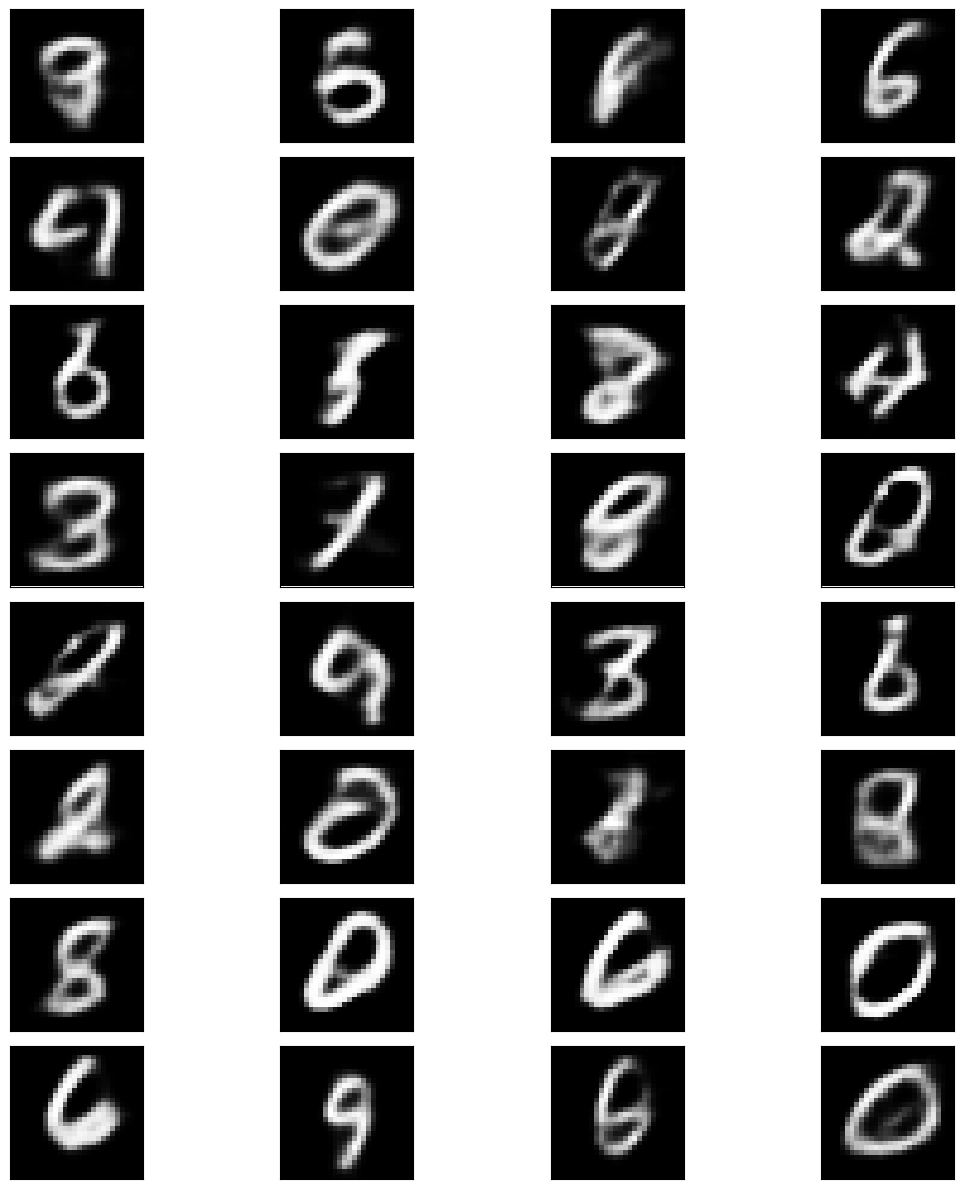

In [28]:
generated_images = sample_ddim(ddpm, vae, sample_count=32)

import matplotlib.pyplot as plt

def display_images(img_tensor):
    # Convert tensor to NumPy array for plotting
    img_array = img_tensor.detach().cpu().numpy()

    # Create a grid of 4x4 subplots
    fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(12, 12))

    # Loop through each subplot and display an image in grayscale
    for idx, ax in enumerate(axs.flat):
        ax.imshow(img_array[idx, 0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

display_images(generated_images)


In [15]:
wandb.finish()

In [16]:
# from google.colab import runtime
# runtime.unassign()